# COMP 7570 Project -  Ripple Metrics

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from data_api.ripple_data_api import RippleDataAPIClient

In [3]:
api = RippleDataAPIClient('https://data.ripple.com')

### Trade Volume

In [107]:
trade_volume = api.get_exchange_volume()

df_row_trade_volume = pd.DataFrame.from_dict(trade_volume['rows'][0]['components'], orient='columns')

In [5]:
df_trade_volume = pd.DataFrame('0',index=range(0,len(df_row_trade_volume)),columns=['base_currency','counter_currency',
                                                                                    'amount'])

In [6]:
for index,row in df_row_trade_volume.iterrows():    
    df_trade_volume.iloc[index]['base_currency'] = row['base']['currency']
    df_trade_volume.iloc[index]['counter_currency'] = row['counter']['currency']
    df_trade_volume.iloc[index]['amount'] = row['amount']

In [7]:
df_trade_volume

,base_currency,counter_currency,amount
0,USD,XRP,163878.1501577777
1,BTC,XRP,12.668209469173757
2,EUR,XRP,43687.892872592674
3,CNY,XRP,324999.1837979492
4,CNY,XRP,212180.58695550624
5,CNY,CNY,116642.82071689889
6,USD,XRP,16174.432046301446
7,ULT,XRP,322860.69044149516
8,CNY,USD,43983.06345129577
9,CNY,ULT,39197.010248393104


In [8]:
df_trade_volume['amount'] = df_trade_volume['amount'].astype('float')

In [9]:
#grouping values by base currenvy and counter currency (we will show the total trade considering all exchanges)
df_trade_volume = df_trade_volume.groupby(['base_currency','counter_currency'])['amount'].agg('sum').to_frame('total_amount') \
                                                                                                    .reset_index()

In [10]:
df_trade_volume['trade_currencies'] = df_trade_volume["base_currency"] + "/" + df_trade_volume["counter_currency"]

In [11]:
df_trade_volume.drop(columns=["base_currency","counter_currency"], inplace=True)

In [12]:
df_trade_volume

,total_amount,trade_currencies
0,0.001950,BTC/USD
1,12.704821,BTC/XRP
2,116642.820717,CNY/CNY
3,516.245567,CNY/EUR
4,39197.010248,CNY/ULT
5,43983.063451,CNY/USD
6,2908.716515,CNY/XLM
7,537179.770753,CNY/XRP
8,8.342747,ETH/XRP
9,831.350634,EUR/USD


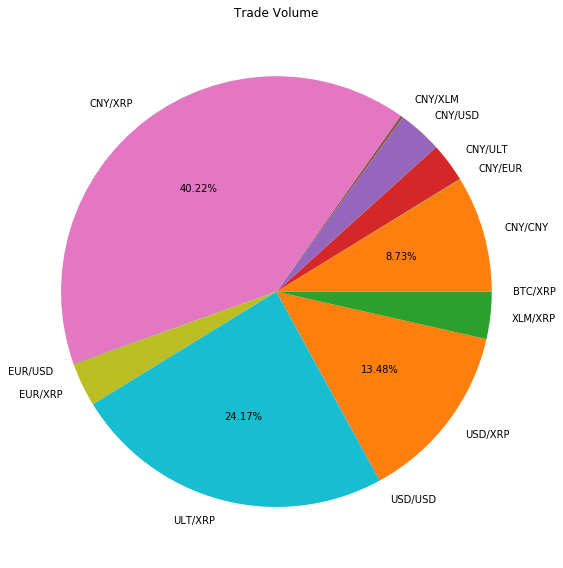

In [58]:
#function for disconsider to show % on the chart for low values
def my_autopct(pct):
    return ('%.2f%%' % pct) if pct > 5 else ''

#excluding some law values from the dataframe (they are really hard to see)
df_trade_volume = df_trade_volume.drop(index = df_trade_volume[df_trade_volume.total_amount < 9].index)

series = pd.Series(df_trade_volume['total_amount'].values, index=df_trade_volume['trade_currencies'], 
                   name='')
series.plot.pie(autopct=my_autopct, figsize=(8,8))

plt.title('Trade Volume')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Trade Volume:</b> We can see by the graph and table above that 30.93% of all exchange are between USD and XRP,
    folowed by CNY (Chinese Yuan) and XRP. 
</div>

### XRP Distribution

In [14]:
xrp_dist_row = api.get_xrp_distribution()
df_xrp_dist = pd.DataFrame.from_dict(xrp_dist_row['rows'], orient='columns')

In [15]:
df_xrp_dist['year'] = df_xrp_dist['date'].str.slice(0,4)
df_xrp_dist['month'] = df_xrp_dist['date'].str.slice(5,7)
df_xrp_dist['day'] = df_xrp_dist['date'].str.slice(8,10)

In [16]:
df_xrp_dist = df_xrp_dist.drop(columns=['date'])

In [17]:
df_xrp_dist

,total,distributed,undistributed,escrowed,year,month,day
0,99997364318,35108326973,64889037345,NaN,2016,06,05
1,99997344164,35108308819,64889035345,NaN,2016,06,12
2,99997334029,35345983560,64651350469,NaN,2016,06,19
3,99997322412,35345971933,64651350479,NaN,2016,06,26
4,99997309184,35438268570,64559040613,NaN,2016,07,03
...,...,...,...,...,...,...,...
172,99991321535,43242653330,6748668193,50000000013,2019,10,13
173,99991316762,43248091671,6743225077,50000000013,2019,10,20
174,99991308084,43268247816,6723060255,50000000013,2019,10,27
175,99991298961,43298481757,6792817191,49900000013,2019,11,03


In [18]:
group_day_max = df_xrp_dist.groupby(['year','month'])['day'].agg('max').to_frame('max_day').reset_index()
df_xrp_dist = df_xrp_dist.merge(group_day_max, left_on=['year','month','day'], right_on=['year','month','max_day'])

df_xrp_dist['date'] = df_xrp_dist['year'] + "-" + df_xrp_dist['month']

df_xrp_dist.drop(columns=['max_day','year','month','day'], inplace=True)

In [19]:
df_xrp_dist.head()

,total,distributed,undistributed,escrowed,date
0,99997322412,35345971933,64651350479,NaN,2016-06
1,99997268571,35557883251,64439385320,NaN,2016-07
2,99997213110,35316813001,64680400109,NaN,2016-08
3,99997179232,35475196836,64521982395,NaN,2016-09
4,99997006553,35649569539,64347437014,NaN,2016-10


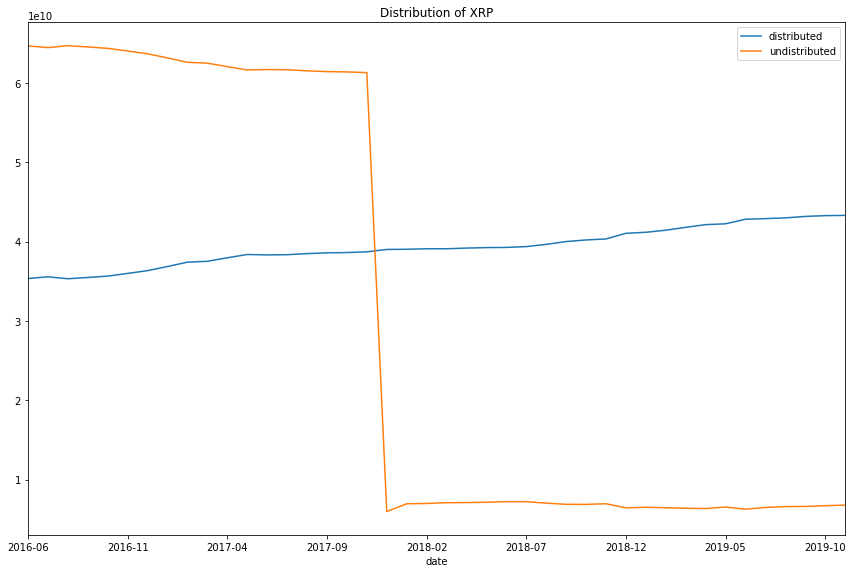

In [20]:
test = pd.DataFrame(df_xrp_dist[['distributed','undistributed']].values.astype('float'), index=df_xrp_dist['date'],
             columns=['distributed','undistributed'])


test.plot(figsize=(12,8))
plt.tight_layout()
plt.title('Distribution of XRP')
plt.show()

<div class="alert alert-block alert-info">
<b>XRP Distribution:</b> The big drop of undistributed XRP in 2017-12 is due to Ripple pacing 55 billion XRP in a escrow account. More information on this: 
    <a href="https://ripple.com/insights/ripple-escrows-55-billion-xrp-for-supply-predictability/">Ripple Escrows 55 Billion XRP for Supply Predictability</a>
</div>

### Payment Volume by Currency

In [79]:
volume = api.get_payment_volume()

df_volume = pd.DataFrame.from_dict(volume['rows'][0]['components'], orient='columns')
df_volume

,currency,amount,count,rate,converted_amount,issuer
0,XRP,218648958.83490846,43061,1.0000000,218648958.83490846,NaN
1,USD,675253.1286309264,21,0.21287649,3172041.84143018,rvYAfWj5gh67oV6fW32ZzP3Aw4Eubs59B
2,CNY,396793,6,1.5694503,252822.9227141825,razqQKzJRdB4UxFPWf5NEpEG3WMkmwgcXA
3,EUR,18176.14,25,0.20362967,89260.76433275781,rhub8VRN55s94qWKDv6jmDy1pUykJzF3wq
4,BTC,2.0842,8,0.000030085205,69276.57547770868,rchGBxcD1A1C2tdxF6papQYZ8kjRKMYcL
5,CNY,95090,3,1.5774980,60278.99975859786,rKiCet8SdvWxPXnAgYarFUXMh1zCPz432Y
6,ETH,3.7102565461874297,3,0.0014513506,2556.416480382721,rcA8X3TVMST1n3CJeAdGk1RdRCHii7N2h
7,USD,100,1,0.22590536,442.6632545724249,rhub8VRN55s94qWKDv6jmDy1pUykJzF3wq


In [22]:
df_volume['amount'] = df_volume['amount'].astype('float')

In [23]:
#grouping values by currency (we will show the total volume considering all issuers)
df_volume = df_volume.groupby(['currency'])['amount'].agg('sum').to_frame('total_amount').reset_index()

In [24]:
df_volume

,currency,total_amount
0,BTC,6.085200e+00
1,CNY,4.918830e+05
2,ETH,4.421381e+00
3,EUR,5.158654e+04
4,USD,6.793531e+05
5,XRP,2.323984e+08


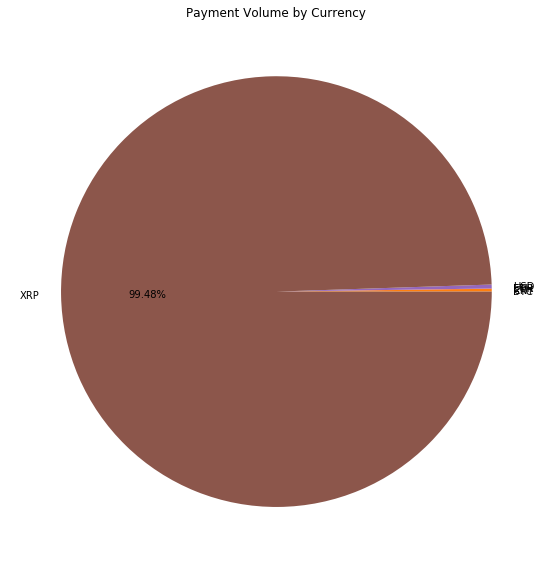

In [25]:
#function for disconsider to show % on the chart for low values
def my_autopct(pct):
    return ('%.2f%%' % pct) if pct > 5 else ''

series = pd.Series(df_volume['total_amount'].values, index=df_volume['currency'], name='')
series.plot.pie(labels=df_volume['currency'], autopct=my_autopct, figsize=(8,8))

plt.title('Payment Volume by Currency')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Payment Volume:</b> We can see by the graph and table above that 99.83% of all payments are made in XRP. 
</div>

### Top Currencies - Based on the average number of daily payments

In [76]:
top_currencies = api.get_top_currencies()

df_top_currencies = pd.DataFrame.from_dict(top_currencies['currencies'], orient='columns')

In [39]:
df_top_currencies['avg_payment_count'] = df_top_currencies['avg_payment_count'].astype('float')

In [47]:
#grouping the currencies - considering the total (not separating by issuer)
total_num_payments = df_top_currencies.groupby('currency')['avg_payment_count'].agg('sum').to_frame('avg_payment_total') \
                                                                                          .reset_index()
total_num_payments.sort_values('avg_payment_total', ascending = False, inplace=True)

In [48]:
total_num_payments.head()

,currency,avg_payment_total
6,USD,116.635417
0,BTC,73.031250
1,CNY,43.935179
4,GMT,41.300000
3,EUR,24.687500


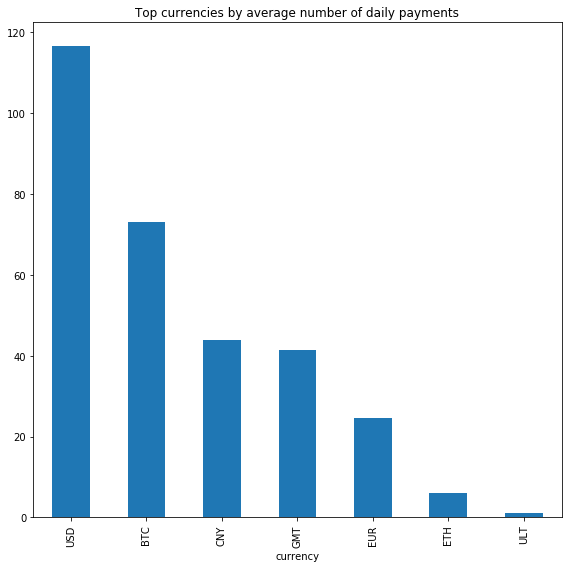

In [51]:
series = pd.Series(total_num_payments['avg_payment_total'].values, index=total_num_payments['currency'], name='')
series.plot.bar(figsize=(8,8))

plt.title('Top currencies by average number of daily payments')
plt.tight_layout()
plt.show()

### Number of new accounts created

In [105]:
params = dict(start='2019-11-01', end='2019-11-30', limit=1000)
accounts = api.get_accounts(**params)

count = 0
    
while 'marker' in accounts:
    count = count + accounts['count']
    param_marker = dict(marker=accounts['marker'],limit=1000)
    accounts = api.get_accounts(**param_marker)

print(f'Number of new accounts created in November, 2019: {count}')

Number of new accounts created in November, 2019: 27000


### Exchange rate overtime - CNY/XRP

In [160]:
exchange_rate_df = pd.DataFrame('0',index=range(0,28),columns=['rate','date'])

In [163]:
idx=0

for i in range(1, 29):
    date_string = '2019-11-' + str(i).zfill(2)
    params = dict(date = date_string)
    
    exchange_rate_df.loc[idx]['date'] = date_string
    exchange_rate_df.loc[idx]['rate'] = api.get_exchange_rates(base='CNY+rKiCet8SdvWxPXnAgYarFUXMh1zCPz432Y', counter='XRP', 
                                                      **params)['rate']    
    
    idx += 1

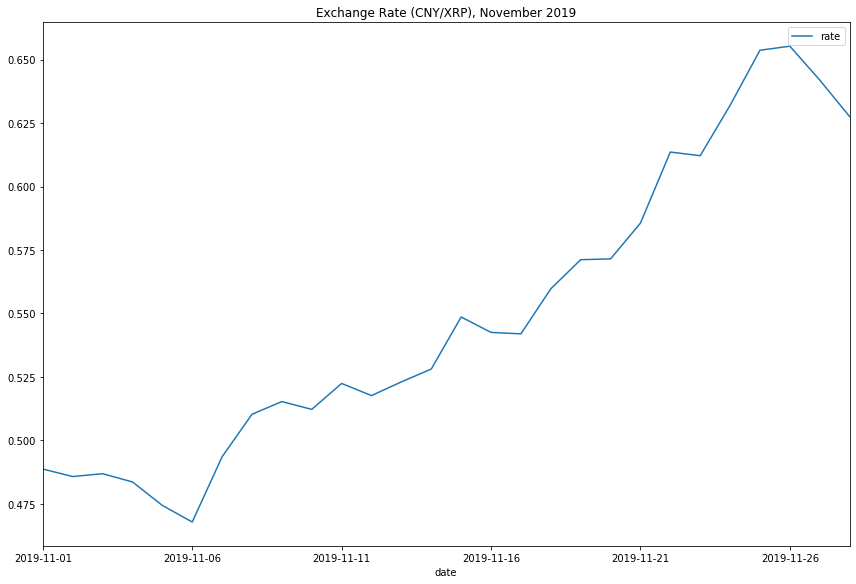

In [165]:
exchange_rate = pd.DataFrame(exchange_rate_df[['rate']].values.astype('float'), index=exchange_rate_df['date'],
             columns=['rate'])


exchange_rate.plot(figsize=(12,8))
plt.tight_layout()
plt.title('Exchange Rate (CNY/XRP), November 2019')
plt.show()